# Simple Reinforcement Learning Examples

### Installs & Imports

In [1]:
# Environmental dependencies.
import gym
import numpy as np
import os

In [2]:
# Widgets dependencies.
from tqdm.notebook import tqdm

In [3]:
# HTML dependencies.
import base64
from IPython.display import HTML, display, clear_output

In [4]:
# Tensorforce dependencies.
from tensorforce import Agent, Environment, Runner

In [5]:
# Plotting dependencies.
import matplotlib.pyplot as plt
%matplotlib inline

### Parameters

In [6]:
episodes = 500
seed = 132
env_names = [ 'CartPole-v1', 'LunarLander-v2' ]
experiment_name = 'Simple Reinforcement Learning Examples'

np.random.seed(seed)

### Load Utility Functions

In [7]:
%run ./fa.intelligence.notebooks/utilities/common/imaging.ipynb

### Environments

In [8]:
def create_environments(environment_names, seed):
    environments = { name: {} for name in environment_names }
    
    for e in environments:
        environments[e]['environment'] = gym.make(e)
        environments[e]['environment'].seed(seed)
        
    return environments

In [9]:
environments = create_environments(env_names, seed)

### Random Agents

In [10]:
for e in environments:
    env = environments[e]['environment']
    frames = environments[e]['random_run_frames'] = []
    done = False
    state = env.reset()
    environments[e]['random_run_reward'] = 0
    
    while not done:
        state, reward, done, info = env.step(env.action_space.sample())
        environments[e]['random_run_reward'] += reward
        frames.append(rgb_array_to_image(env.render(mode='rgb_array')))
    
    print(f'[{e}][RANDOM_AGENT] Reward: {environments[e]["random_run_reward"]}')

C:\ProgramData\miniforge3\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


[CartPole-v1][RANDOM_AGENT] Reward: 16.0
[LunarLander-v2][RANDOM_AGENT] Reward: -286.6629894699233


### Intelligent Agents

#### Tensorforce

In [11]:
def create_tensorforce_agent(env_name, gym_environment, model_path='./data/models/tf.{}.{}'):
    gym_environment.reset()
    normalized_path = model_path.format(env_name.lower(), experiment_name.lower().replace(' ','_'))
    environment = Environment.create(environment=gym_environment)
    does_model_exist = os.path.exists(normalized_path)
    agent = None
    
    if does_model_exist:
        print(f'Loading existing model.')
        agent = Agent.load(directory=normalized_path, format='checkpoint', environment=environment)
    else:
        print(f'No directory "{normalized_path}" exists. Creating a new model.')
        #agent = Agent.create(
        #    saver=dict(
        #        directory=normalized_path,
        #        frequency=50,
        #        max_checkpoints=5
        #    ),
        #    agent='double_dqn',
        #    environment=environment,
        #    memory=15000,
        #    batch_size=10000
        #)
        agent = Agent.create(
            saver=dict(
                directory=normalized_path,
                frequency=50,
                max_checkpoints=5
            ),
            agent='tensorforce', 
            environment=environment, 
            update=64,
            optimizer=dict(optimizer='adam', learning_rate=1e-3),
            objective='policy_gradient', 
            memory=15000,
            reward_estimation=dict(horizon=20)
        )
    
    return agent, environment

In [12]:
for e in environments:
    env_rewards = environments[e]['tf_rewards'] = []
    env = environments[e]['environment']
    tf_agent, tf_environment = create_tensorforce_agent(e, env)
    
    for episode_index in range(episodes):
        states = tf_environment.reset()
        terminal = False
        episode_reward = 0
        
        while not terminal:
            actions = tf_agent.act(states=states)
            states, terminal, reward = tf_environment.execute(actions=actions)
            tf_agent.observe(terminal=terminal, reward=reward)
            episode_reward += reward

        env_rewards.append(episode_reward)
        clear_output(wait=True)
        print(f'Environment: "{e}" > TensorForce > Episode {episode_index + 1}/{episodes} > Reward: {round(episode_reward, 3)}.')
        
    tf_agent.close()
    tf_environment.close()

Environment: "LunarLander-v2" > TensorForce > Episode 500/500 > Reward: -141.648.


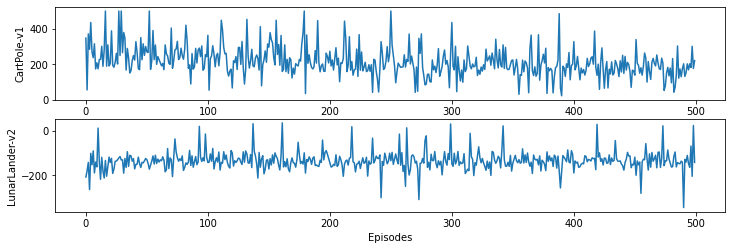

In [13]:
fig = plt.figure(figsize=(12,12))

for i, e in enumerate(environments):
    ax1 = plt.subplot(6, 1, i + 2)
    ax1.plot(environments[e]['tf_rewards'], label = e)
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel(e)

In [14]:
for e in environments:
    frames = environments[e]['tf_run_frames'] = []
    env = environments[e]['environment']
    tf_agent, tf_environment = create_tensorforce_agent(e, env)
    
    states = tf_environment.reset()
    terminal = False
    environments[e]['tf_run_reward'] = 0
    
    while not terminal:
        actions = tf_agent.act(states=states, independent=True)
        states, terminal, reward = tf_environment.execute(actions=actions)
        environments[e]['tf_run_reward'] += reward
        render = env.render(mode='rgb_array')
        frames.append(rgb_array_to_image(render))

Loading existing model.


Loading existing model.


### Visualize Results

In [17]:
environments_html = ''

for e in environments:
    random_frames = environments[e]['random_run_frames']
    random_run_gif = images_to_gif_bytes(random_frames)
    random_run_reward = round(environments[e]['random_run_reward'], 2)
    
    tf_frames = environments[e]['tf_run_frames']
    tf_run_gif = images_to_gif_bytes(tf_frames)
    tf_run_reward = round(environments[e]['tf_run_reward'], 2)
    
    environments_html += f'<div style="display: inline-block; padding: 15px"><div style="font-weight:bold">{e} - Random Agent</div><div style="padding: 5px"><img style="width: 150px; padding: 5px" src="data:image.gif;base64, {base64.b64encode(random_run_gif).decode()}" /></div><div>Reward: {random_run_reward}</div></div>'
    environments_html += f'<div style="display: inline-block; padding: 15px"><div style="font-weight:bold">{e} - TensorForce Agent</div><div style="padding: 5px"><img style="width: 150px; padding: 5px" src="data:image.gif;base64, {base64.b64encode(tf_run_gif).decode()}" /></div><div>Reward: {tf_run_reward}</div></div>'

In [18]:
HTML(f'<h1 style="text-align:center">{experiment_name}</h1><div style="text-align: center">{environments_html}</div><footer style="text-align: center; padding: 15px">FrostAura Intelligence</footer>')